### Análise dos Covenants Contábeis divulgados pelas empresas listadas na B3 (2010 a 2022)

In [89]:
## bibliotecas usadas
import pandas as pd
import numpy as np
import unicodedata
import os
import re
# visualização
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
# análise
from concurrent.futures import ThreadPoolExecutor
from rapidfuzz import fuzz, process



### A análise começou com a coleta manual das notas explicativas publicadas pelas empresas no site da B3 Investidor, como também da Comissão de Valores Mobiliários (CVM).
Após coleta fiz um script para ler todos os pdfs (disponível no github: `link`) e separar em uma pasta todos que citaram covenants ou cláusulas restritivas.

In [90]:
empresas_df = pd.read_excel("Empresas_com_covenants.xlsx")
# empresas_df = pd.read_excel("C:\{estudos}\Covenants - pibic\Covenants-Contabeis\Empresas_com_covenants.xlsx")
empresas_df.head()

,Empresa,Quantidade de Anos
0,Hidrovias do Brasil,11
1,Ambipar Participacoes e Empreendimentos,4
2,Plano & Plano Desenvolvimento Imobiliario SA,4
3,Renner,13
4,B3 SA Brasil Bolsa Balcao,3


In [91]:
empresas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Empresa             282 non-null    object
 1   Quantidade de Anos  282 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.5+ KB


### Selecionando agora a base de dados da análise manual
Empresas que citaram termos como "covenants" ou cláusulas "restritivas" e foram submetidas a análise manual das notas explicativas coletadas.

### Dicionário de Variáveis — Base de Análise Manual dos Covenants

Esta base contém informações extraídas manualmente das notas explicativas de empresas que mencionaram termos como **"covenants"** ou cláusulas **"restritivas"**. As empresas listadas passaram por um processo de verificação e categorização quanto à existência e divulgação dessas cláusulas.

| Coluna                               | Descrição |
|-------------------------------------|-----------|
| **EMPRESA**                         | Nome padronizado da empresa analisada (em letras maiúsculas e sem espaços extras). |
| **ANO**                             | Ano em que foi feita a análise da nota explicativa da empresa. |
| **POSSUI COVENANT**                 | Indica se a empresa possui cláusulas financeiras restritivas (covenants). Valores possíveis: `Sim`, `Não`, `Não encontrado`. |
| **DIVULGOU**                        | Indica se a empresa divulgou informações detalhadas sobre os covenants identificados. Valores possíveis: `Sim`, `Parcial`, `Não`. |
| **Debenture ou Empréstimos e financiamento** | Tipo de contrato relacionado ao covenant. Informa se o covenant foi associado a **debêntures**, **empréstimos e financiamentos** ou outro tipo de instrumento financeiro. |
| **Índice Utilizado**                | Índice financeiro citado na cláusula. Pode ser, por exemplo, `Dívida Líquida/EBITDA`, `Cobertura de Juros`, `Liquidez Corrente`, etc. |
| **Limite**                          | Valor de referência imposto pelo covenant. Pode ser um número absoluto, uma razão financeira ou um percentual. |
| **Violou?**                         | Indica se houve **descumprimento** (violação) do covenant no período analisado. Valores possíveis: `Sim`, `Não`, `Não divulgado`. |

> **Observações Importantes**:
> - Algumas empresas citam o termo **covenant** sem, de fato, detalhar a cláusula ou apresentar as condições contratuais.
> - Em alguns casos, a nota explicativa revela a **existência** do covenant, mas não especifica o **índice, limite ou situação de violação**.



In [92]:
covenants = pd.read_excel("Base Covenants Contabeis.xlsx")
covenants.tail()

,EMPRESA,ANO,POSSUI COVENANT,DIVULGOU,Debenture ou Empréstimos e financiamento,Índice Utilizado,Limite,Violou?
6267,Zamp,2021.0,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,SIM
6268,Zamp,2022.0,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,NÃO
6269,Zamp,2022.0,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,NÃO
6270,Zamp,2023.0,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,NÃO
6271,Zamp,2023.0,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,NÃO


In [93]:
covenants['Índice Utilizado'].nunique()

260

In [94]:
covenants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6272 entries, 0 to 6271
Data columns (total 8 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   EMPRESA                                   6267 non-null   object 
 1   ANO                                       6257 non-null   float64
 2   POSSUI COVENANT                           6265 non-null   object 
 3   DIVULGOU                                  5990 non-null   object 
 4   Debenture ou Empréstimos e financiamento  5249 non-null   object 
 5   Índice Utilizado                          5209 non-null   object 
 6   Limite                                    4833 non-null   object 
 7   Violou?                                   4620 non-null   object 
dtypes: float64(1), object(7)
memory usage: 392.1+ KB


> Houve uma redução de 282 empresas para 259 na análise manual porque foi retirada empresas do setor financeiro e que disponibilizaram menos de duas notas explicativas desde 2010

In [95]:
covenants['EMPRESA'].nunique()

259

### Tratamento da base de dados

In [96]:
covenants.dropna(subset=['ANO'], inplace=True)
covenants['ANO'] = covenants['ANO'].astype(int)

# limpeza coluna 'Limite'
valores_unicos = covenants['Limite'].dropna().unique()
valores_unicos

array(['menor ou igual a 3,5', 'menor ou igual a 4,5',
       'maior ou igual a 1,25', 'maior ou igual a 1,2',
       'maior ou igual a 1,3', 'maior ou igual a 1', 'menor ou igual a 3',
       'maior ou igual a 1,1', 'menor ou igual a 2,5',
       'maior ou igual a 1,75', 'menor ou igual a 3,6',
       'maior ou igual a 1,76', 'maior ou igual a 1,5',
       'menor ou igual a 3,75', 'maior ou igual a 1,10',
       'menor ou igual a 5,6', 'maior ou igual a 1,15',
       'menor ou igual a 1,9 bi', 'menor ou igual a 338 mi',
       'menor ou igual a 840 mi', 'menor ou igual a 285 mi',
       'maior ou igual a 20%', 'menor ou igual a 50 mi',
       'maior ou igual a 41 mi', 'menor ou igual a 164 mi',
       'menor ou igual a 225 mi', 'maior ou igual a 1,20',
       'maior ou igual a 3,75', 'menor ou igual a 1,75',
       'menor ou igual a 0,6', 'maior ou igual a 3,50',
       'maior ou igual a 0,6', 'menor ou igual a 2,75',
       'menor ou igual a 2,50', 'menor ou igual a 3,0',
       'men

In [97]:
# Função para normalizar o texto (remove acentos e converte para minúsculo)
def normalizar_texto(texto):
    texto = str(texto).lower().strip()
    texto = texto.replace(',', '.')
    texto = re.sub(r'\s+', ' ', texto)  # remove espaços duplos
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')
    return texto

# Lista de operadores em regex
operadores_regex = (
    r'(maior ou igual a|maior ou igual|menor ou igual a|menor ou igual|'
    r'maior que|menor que|igual a)'
)

# Função principal
def extrair_limite(texto):
    if pd.isnull(texto):
        return pd.Series([None, None])

    texto_original = texto  # para verificar se tem %
    texto = normalizar_texto(texto)

    # Ignorar se houver unidades monetárias ou palavras irrelevantes
    if any(unidade in texto for unidade in ['r$', 'milhao', 'milhoes', 'mi', 'pl', 'depreciacao', 'amortizacao']):
        return pd.Series([None, None])

    # Detectar porcentagem
    tem_porcentagem = '%' in texto_original

    # Regex para operador e valor
    padrao = fr'{operadores_regex}\s*([0-9.]+)'
    match = re.search(padrao, texto)

    if match:
        operador = match.group(1).strip()
        try:
            valor = float(match.group(2))
            if tem_porcentagem:
                valor = valor / 100
            return pd.Series([operador, valor])
        except:
            return pd.Series([operador, None])

    return pd.Series([None, None])

covenants[['operador_limite', 'valor_limite']] = covenants['Limite'].apply(extrair_limite)
covenants.tail()



,EMPRESA,ANO,POSSUI COVENANT,DIVULGOU,Debenture ou Empréstimos e financiamento,Índice Utilizado,Limite,Violou?,operador_limite,valor_limite
6267,Zamp,2021,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,SIM,menor ou igual a,3.0
6268,Zamp,2022,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,NÃO,menor ou igual a,3.0
6269,Zamp,2022,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,NÃO,menor ou igual a,3.0
6270,Zamp,2023,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,NÃO,menor ou igual a,3.0
6271,Zamp,2023,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,NÃO,menor ou igual a,3.0


In [98]:
df_empresas_setores = pd.read_excel("Setores das empresas B3.xlsx")
df_empresas_setores.columns = df_empresas_setores.columns.str.strip()
lista_nomes = df_empresas_setores["Nome da empresa no pregão"].dropna().tolist()
df_empresas_setores

,Nome da empresa no pregão,Ticker na bolsa,Setor
0,AERIS,AERI3,Bens Industriais
1,ARMAC,ARML3,Bens Industriais
2,ATMASA,ATMP3,Bens Industriais
3,AZEVEDO,AZEV4,Bens Industriais
4,AZUL,AZUL4,Bens Industriais
...,...,...,...
370,POLPAR,PPAR3,Outros
371,PROMPT PART,PRPT3,Outros
372,SUDESTE S/A,OPSE3,Outros
373,SUL 116 PART,OPTS3,Outros


A estrutura (Bens Industriais, Consumo Cíclico, etc.) corresponde à classificação setorial oficial da B3 (Brasil, Bolsa, Balcão). Essa classificação, por sua vez, é uma adaptação do padrão global *GICS (Global Industry Classification Standard)*, que é utilizado pelas maiores agências de classificação e provedores de dados financeiros do mundo (como S&P, MSCI, Refinitiv, Bloomberg).

Portanto, para artigos e análises na área de finanças e contabilidade, utilizar esta classificação é não apenas aceitável, mas altamente recomendável. Isso garante que sua pesquisa seja:

`Comparável:` Seus resultados podem ser diretamente comparados com os de outros trabalhos que usam o mesmo padrão.

`Robusta:` Você está usando uma metodologia de classificação consolidada, e não uma divisão subjetiva.

`Reconhecida:` Analistas de mercado, investidores e outros pesquisadores entendem imediatamente a que você se refere.

In [99]:
df_empresas_setores['Setor'].unique()

array(['Bens Industriais', 'Comunicações', 'Consumo Cíclico',
       'Consumo Não Cíclico', 'Financeiro', 'Materiais Básicos',
       'Petróleo, Gás e Biocombustíveis ', 'Saúde',
       'Tecnologia da Informação', 'Utilidade Pública', 'Outros'],
      dtype=object)

##### Para análisar mais a fundo o setor de utilidade pública no artigo

In [100]:
empresas_unicas = df_empresas_setores[df_empresas_setores['Setor'] == 'Utilidade Pública']['Ticker na bolsa'].unique()
empresas_unicas

array(['AESB3\xa0', 'AFLT3\xa0', 'ALUP11\xa0', 'AMBP3\xa0', 'CBEE3\xa0',
       'AURE3\xa0', 'CASN4\xa0', 'CEBR5\xa0', 'CLSC4\xa0', 'GPAR3\xa0',
       'CMIG4\xa0', 'CEEB5\xa0', 'COCE5\xa0', 'COMR3\xa0', 'CSMG3\xa0',
       'CPLE5\xa0', 'CSRN5\xa0', 'CPFE3\xa0', 'EKTR4\xa0', 'ELET5\xa0',
       'LIPR3\xa0', 'EMAE4\xa0', 'ENGI11\xa0', 'ENMT4\xa0', 'ENEV3\xa0',
       'EGIE3\xa0', 'EQTL3\xa0', 'GEPA4\xa0', 'IGSN3\xa0', 'LIGT3\xa0',
       'NEOE3\xa0', 'ORVR3\xa0', 'REDE3\xa0', 'RNEW11\xa0', 'SBSP3\xa0',
       'SAEN3\xa0', 'SAPR11\xa0', 'SRNA3\xa0', 'TAEE11\xa0', 'TRPL4\xa0'],
      dtype=object)

In [101]:
tickers_sujos = np.array(['AESB3\xa0', 'AFLT3\xa0', 'ALUP11\xa0', 'AMBP3\xa0', 'CBEE3\xa0',
                          'AURE3\xa0', 'CASN4\xa0', 'CEBR5\xa0', 'CLSC4\xa0', 'GPAR3\xa0',
                          'CMIG4\xa0', 'CEEB5\xa0', 'COCE5\xa0', 'COMR3\xa0', 'CSMG3\xa0',
                          'CPLE5\xa0', 'CSRN5\xa0', 'CPFE3\xa0', 'EKTR4\xa0', 'ELET5\xa0',
                          'LIPR3\xa0', 'EMAE4\xa0', 'ENGI11\xa0', 'ENMT4\xa0', 'ENEV3\xa0',
                          'EGIE3\xa0', 'EQTL3\xa0', 'GEPA4\xa0', 'IGSN3\xa0', 'LIGT3\xa0',
                          'NEOE3\xa0', 'ORVR3\xa0', 'REDE3\xa0', 'RNEW11\xa0', 'SBSP3\xa0',
                          'SAEN3\xa0', 'SAPR11\xa0', 'SRNA3\xa0', 'TAEE11\xa0', 'TRPL4\xa0'],
                         dtype=object)

# Limpando os sufixos '\xa0' e espaços em branco de cada ticker
tickers_limpos = [ticker.replace('\xa0', '').strip() for ticker in tickers_sujos]

# Dicionário com os dados pesquisados (Empresa e Subsetor)
# Esta etapa foi feita com base em consultas de dados de mercado para cada ticker.
dados_empresas = {
    'AESB3': ('AES Brasil', 'Energia Elétrica'),
    'AFLT3': ('Afluente T', 'Energia Elétrica'),
    'ALUP11': ('Alupar', 'Energia Elétrica'),
    'AMBP3': ('Ambipar', 'Água e Saneamento'), # Atua em gestão de resíduos
    'CBEE3': ('Celesc', 'Energia Elétrica'), # Holding da CLSC4
    'AURE3': ('Auren Energia', 'Energia Elétrica'),
    'CASN4': ('Casal', 'Água e Saneamento'), # Cia de Saneamento de Alagoas
    'CEBR5': ('CEB', 'Energia Elétrica'), # Cia Energética de Brasília
    'CLSC4': ('Celesc', 'Energia Elétrica'), # Cia Energética de Santa Catarina
    'GPAR3': ('Celgpar', 'Energia Elétrica'), # Companhia Celg de Participações
    'CMIG4': ('Cemig', 'Energia Elétrica'),
    'CEEB5': ('Coelba', 'Energia Elétrica'), # Grupo Neoenergia
    'COCE5': ('Coelce', 'Energia Elétrica'), # Enel Ceará
    'COMR3': ('Isa Cteep', 'Energia Elétrica'), # Holding da TRPL4
    'CSMG3': ('Copasa', 'Água e Saneamento'),
    'CPLE5': ('Copel', 'Energia Elétrica'),
    'CSRN5': ('Cosern', 'Energia Elétrica'), # Grupo Neoenergia
    'CPFE3': ('CPFL Energia', 'Energia Elétrica'),
    'EKTR4': ('Elektro', 'Energia Elétrica'), # Grupo Neoenergia
    'ELET5': ('Eletrobras', 'Energia Elétrica'),
    'LIPR3': ('Eletropar', 'Energia Elétrica'), # Holding da Eletrobras
    'EMAE4': ('EMAE', 'Energia Elétrica'), # Empresa Metropolitana de Águas e Energia
    'ENGI11': ('Energisa', 'Energia Elétrica'),
    'ENMT4': ('Energisa MT', 'Energia Elétrica'),
    'ENEV3': ('Eneva', 'Energia Elétrica'),
    'EGIE3': ('Engie Brasil', 'Energia Elétrica'),
    'EQTL3': ('Equatorial Energia', 'Energia Elétrica'),
    'GEPA4': ('Geradora Paranapanema', 'Energia Elétrica'),
    'IGSN3': ('Iguá Saneamento', 'Água e Saneamento'),
    'LIGT3': ('Light', 'Energia Elétrica'),
    'NEOE3': ('Neoenergia', 'Energia Elétrica'),
    'ORVR3': ('Orizon', 'Água e Saneamento'), # Atua em valorização de resíduos
    'REDE3': ('Rede Energia', 'Energia Elétrica'), # Grupo Energisa
    'RNEW11': ('Renova Energia', 'Energia Elétrica'),
    'SBSP3': ('Sabesp', 'Água e Saneamento'),
    'SAEN3': ('Sanepar', 'Água e Saneamento'), # Holding da SAPR11
    'SAPR11': ('Sanepar', 'Água e Saneamento'),
    'SRNA3': ('Serena Energia', 'Energia Elétrica'), # Antiga Omega Energia
    'TAEE11': ('Taesa', 'Energia Elétrica'),
    'TRPL4': ('Isa Cteep', 'Energia Elétrica')
}

dados_para_df = []
for ticker in tickers_limpos:
    empresa, subsetor = dados_empresas.get(ticker, ('Não encontrada', 'Não encontrado'))
    dados_para_df.append({'Ticker': ticker, 'Empresa': empresa, 'Subsetor': subsetor})

df_utilidade_publica = pd.DataFrame(dados_para_df)
df_utilidade_publica.head()

,Ticker,Empresa,Subsetor
0,AESB3,AES Brasil,Energia Elétrica
1,AFLT3,Afluente T,Energia Elétrica
2,ALUP11,Alupar,Energia Elétrica
3,AMBP3,Ambipar,Água e Saneamento
4,CBEE3,Celesc,Energia Elétrica


In [102]:
df = covenants.copy()

df["EMPRESA"] = df["EMPRESA"].str.strip().str.upper()
df_empresas_setores["Nome da empresa no pregão"] = df_empresas_setores["Nome da empresa no pregão"].str.strip().str.upper()

def match_nome(nome, lista_nomes, threshold=60):
    melhor_match = process.extractOne(nome, lista_nomes, scorer=fuzz.partial_ratio)
    if melhor_match and melhor_match[1] >= threshold:
        return melhor_match[0]
    return None


# Aplica o fuzzy match e salva em nova coluna
with ThreadPoolExecutor() as executor:
    resultados = list(executor.map(lambda x: match_nome(x, lista_nomes), df["EMPRESA"]))
df['Empresa_Setor'] = resultados

# Remove espaços e caracteres invisíveis como \xa0 de ambas as colunas usadas no merge
df['Empresa_Setor'] = df['Empresa_Setor'].str.strip().str.replace('\xa0', '', regex=False).str.upper()
df_empresas_setores["Nome da empresa no pregão"] = df_empresas_setores["Nome da empresa no pregão"].str.strip().str.replace('\xa0', '', regex=False).str.upper()

colunas_adicionais = ["Ticker na bolsa", "Setor"]

# Faz merge usando a coluna ajustada
df_merged = pd.merge(
    df,
    df_empresas_setores[["Nome da empresa no pregão"] + colunas_adicionais],
    left_on="Empresa_Setor",
    right_on="Nome da empresa no pregão",
    how="left"
)

# Exporta e mostra os dados
df_merged.to_excel("empresas_merge_final.xlsx", index=False)
display(df_merged[["EMPRESA", "Empresa_Setor", "Setor", "Ticker na bolsa"]].head(10))

,EMPRESA,Empresa_Setor,Setor,Ticker na bolsa
0,AERIS INDUSTRIA E COMERCIO DE EQUIPAMENTOS PAR...,AERIS,Bens Industriais,AERI3
1,AERIS INDUSTRIA E COMERCIO DE EQUIPAMENTOS PAR...,AERIS,Bens Industriais,AERI3
2,AERIS INDUSTRIA E COMERCIO DE EQUIPAMENTOS PAR...,AERIS,Bens Industriais,AERI3
3,AERIS INDUSTRIA E COMERCIO DE EQUIPAMENTOS PAR...,AERIS,Bens Industriais,AERI3
4,AERIS INDUSTRIA E COMERCIO DE EQUIPAMENTOS PAR...,AERIS,Bens Industriais,AERI3
5,AES BRASIL ENERGIA,AES BRASIL,Utilidade Pública,AESB3
6,AES BRASIL ENERGIA,AES BRASIL,Utilidade Pública,AESB3
7,AES BRASIL ENERGIA,AES BRASIL,Utilidade Pública,AESB3
8,AES BRASIL ENERGIA,AES BRASIL,Utilidade Pública,AESB3
9,AES BRASIL ENERGIA,AES BRASIL,Utilidade Pública,AESB3


In [103]:
nao_encontradas = df_merged[df_merged["Setor"].isna()][["EMPRESA", "Empresa_Setor", "Ticker na bolsa"]].drop_duplicates()
print("Empresas não encontradas:", nao_encontradas.shape[0])
display(nao_encontradas.head(10))


Empresas não encontradas: 0


,EMPRESA,Empresa_Setor,Ticker na bolsa


In [104]:
df_merged.drop(columns=["Nome da empresa no pregão"], inplace=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6257 entries, 0 to 6256
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   EMPRESA                                   6257 non-null   object 
 1   ANO                                       6257 non-null   int64  
 2   POSSUI COVENANT                           6250 non-null   object 
 3   DIVULGOU                                  5975 non-null   object 
 4   Debenture ou Empréstimos e financiamento  5234 non-null   object 
 5   Índice Utilizado                          5194 non-null   object 
 6   Limite                                    4818 non-null   object 
 7   Violou?                                   4605 non-null   object 
 8   operador_limite                           4790 non-null   object 
 9   valor_limite                              4790 non-null   float64
 10  Empresa_Setor                       

In [105]:
nova_ordem = ["Empresa_Setor",
    "Setor", "ANO", "POSSUI COVENANT",
    "DIVULGOU",
    "Debenture ou Empréstimos e financiamento",
    "Índice Utilizado",
    "operador_limite",
    "valor_limite",
    "Violou?",
    "Limite",
    "Ticker na bolsa",
    "EMPRESA"]

df_merged = df_merged[nova_ordem]
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6257 entries, 0 to 6256
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Empresa_Setor                             6257 non-null   object 
 1   Setor                                     6257 non-null   object 
 2   ANO                                       6257 non-null   int64  
 3   POSSUI COVENANT                           6250 non-null   object 
 4   DIVULGOU                                  5975 non-null   object 
 5   Debenture ou Empréstimos e financiamento  5234 non-null   object 
 6   Índice Utilizado                          5194 non-null   object 
 7   operador_limite                           4790 non-null   object 
 8   valor_limite                              4790 non-null   float64
 9   Violou?                                   4605 non-null   object 
 10  Limite                              

In [106]:
df_merged["EMPRESA"].nunique()

259

In [107]:
df = df_merged.copy()
df_financeiro = df[df['Setor'] == 'Financeiro'].copy()
financeiro = df_financeiro['Empresa_Setor'].unique()
print(financeiro)

df = df[df['Setor'] != 'Financeiro'].copy()
df.info()

['CIELO' 'CLEARSALE' 'ABC BRASIL' 'CSU DIGITAL' 'GENERALSHOPP' 'GP INVEST'
 'HBR REALTY' 'IGUATEMI S.A' 'INTER CO' 'ITAUSA' 'MONT ARANHA' 'MULTIPLAN'
 'SAO CARLOS' 'SIMPAR' 'SYN PROP TEC' 'IRBBRASILRE' 'WIZ CO']
<class 'pandas.core.frame.DataFrame'>
Index: 5812 entries, 0 to 6256
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Empresa_Setor                             5812 non-null   object 
 1   Setor                                     5812 non-null   object 
 2   ANO                                       5812 non-null   int64  
 3   POSSUI COVENANT                           5805 non-null   object 
 4   DIVULGOU                                  5562 non-null   object 
 5   Debenture ou Empréstimos e financiamento  4850 non-null   object 
 6   Índice Utilizado                          4810 non-null   object 
 7   operador_limite                           

In [108]:
num_empresas = df['Empresa_Setor'].nunique()
print(f"Número de empresas na base: {num_empresas}")

Número de empresas na base: 211


#### Remover empresas que não possuem covenants ou menos de dois anos de dados para análise, como também os dados referentes a 2023

In [109]:
# Tratando base de dados com empresas analisadas
df_possui_covenant = df[df['ANO'] != 2023].copy()
contagem_anos = df_possui_covenant.groupby('Empresa_Setor')['ANO'].nunique()

empresas_validas = contagem_anos[contagem_anos >= 2].index
num_empresas = df_possui_covenant['Empresa_Setor'].nunique()
print(f"Número de empresas na base: {num_empresas}")

Número de empresas na base: 206


In [110]:
# Base apenas para os que possuem covenants
df_1 = df[df['POSSUI COVENANT'] == 'SIM'].copy()
df = df_1[df_1['ANO'] != 2023].copy()
print(df['ANO'].unique())


[2019 2020 2021 2022 2015 2016 2017 2018 2012 2013 2014 2010 2011]


In [139]:
contagem_anos = df.groupby('Empresa_Setor')['ANO'].nunique()

empresas_validas = contagem_anos[contagem_anos >= 2].index
df_filtrado = df[df['Empresa_Setor'].isin(empresas_validas)].copy()
df_filtrado.info()
num_empresas = df_filtrado['Empresa_Setor'].nunique()
print(f"Número de empresas na base: {num_empresas}")

<class 'pandas.core.frame.DataFrame'>
Index: 4974 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Empresa_Setor                             4974 non-null   object 
 1   Setor                                     4974 non-null   object 
 2   ANO                                       4974 non-null   int64  
 3   POSSUI COVENANT                           4974 non-null   object 
 4   DIVULGOU                                  4974 non-null   object 
 5   Debenture ou Empréstimos e financiamento  4407 non-null   object 
 6   Índice Utilizado                          4369 non-null   object 
 7   operador_limite                           4034 non-null   object 
 8   valor_limite                              4034 non-null   float64
 9   Violou?                                   3811 non-null   object 
 10  Limite                                   

In [112]:
df_filtrado['DIVULGOU'] = df_filtrado["DIVULGOU"].replace('NÂO', 'NÃO')
df_filtrado['DIVULGOU'].unique()

array(['NÃO', 'SIM'], dtype=object)

## 1. **Descrição geral da base de dados**

**Objetivo**: contextualizar o leitor sobre sua amostra.

Você pode incluir:

* Número total de empresas e anos analisados.
* Distribuição temporal da presença de covenants (`"POSSUI COVENANT"`).
* Número e proporção de empresas que divulgaram (`"DIVULGOU"`).
* Frequência dos tipos de instrumentos (debêntures vs. empréstimos).
* Frequência de presença de cláusulas com limites e índices.

📌 *Gráficos sugeridos*: histogramas, barras, timeline com linhas empilhadas.

In [113]:
# Padronizando estilo dos gráficos
plt.style.use("default")
azul_escuro = "#0d3b66"

font_titulo = {'family': 'serif', 'color': azul_escuro, 'size': 18}
font_eixos = {'family': 'serif', 'color': azul_escuro, 'size': 13}

def aplicar_estetica():
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.rcParams['axes.edgecolor'] = 'gray'
    plt.rcParams['axes.labelcolor'] = azul_escuro
    plt.rcParams['xtick.color'] = azul_escuro
    plt.rcParams['ytick.color'] = azul_escuro

In [114]:
n_empresas = df_filtrado['Empresa_Setor'].nunique()
anos_analise = df_filtrado['ANO'].nunique()

print(f"Número de empresas analisadas: {n_empresas}"
      f"\nAnos de análise: {anos_analise}")

Número de empresas analisadas: 188
Anos de análise: 13


##### 1. Distribuição temporal da presença de covenants

C:\Users\Maria Eduarda\AppData\Local\Temp\ipykernel_12212\1656300888.py:3: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  ax = sns.countplot(


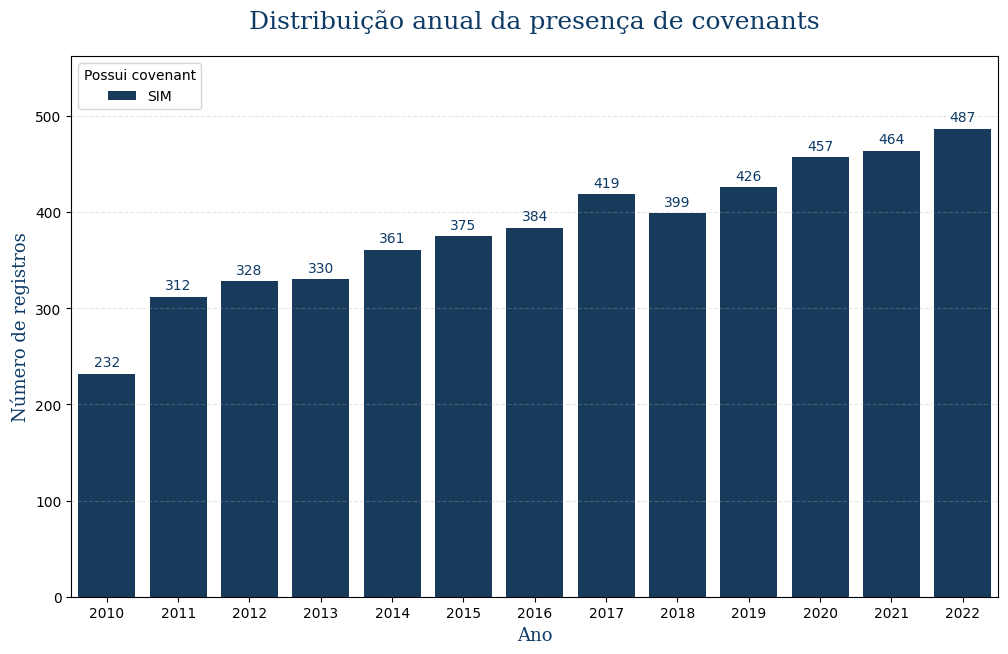

In [115]:
plt.figure(figsize=(10,6))
aplicar_estetica()
ax = sns.countplot(
    data=df_filtrado,
    x="ANO",
    hue="POSSUI COVENANT",
    palette=[azul_escuro, "#d3d3d3"],
    order=sorted(df_filtrado["ANO"].unique())
)

# 2. Loop para adicionar os rótulos em cada barra
for p in ax.patches:
    # p.get_height() é o valor da barra (a contagem)
    # Verificamos se a altura é maior que zero para não rotular barras vazias
    if p.get_height() > 0:
        ax.annotate(
            f'{int(p.get_height())}',                   
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',                               
            va='center',                               
            xytext=(0, 8),                              
            textcoords='offset points',                
            fontsize=10,
            color=azul_escuro
        )

plt.title("Distribuição anual da presença de covenants", fontdict=font_titulo, pad=20)
plt.xlabel("Ano", fontdict=font_eixos)
plt.ylabel("Número de registros", fontdict=font_eixos)
plt.legend(title="Possui covenant", loc="upper left", frameon=True)

plt.ylim(0, ax.get_ylim()[1] * 1.1)
plt.show()

##### 2. Número e proporção de empresas que divulgaram

C:\Users\Maria Eduarda\AppData\Local\Temp\ipykernel_12212\1234702928.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


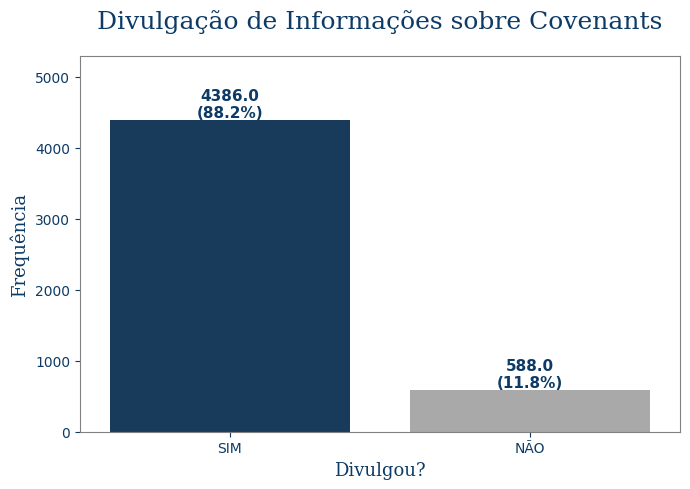

In [116]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(
    data=df_filtrado,
    x="DIVULGOU",
    palette=[azul_escuro, "#a9a9a9"],
    order=df_filtrado["DIVULGOU"].value_counts().index
)
plt.title("Divulgação de Informações sobre Covenants", fontdict=font_titulo, pad=20)
plt.xlabel("Divulgou?", fontdict=font_eixos)
plt.ylabel("Frequência", fontdict=font_eixos)

# Adiciona os rótulos de dados (contagem e porcentagem)
total = len(df_filtrado['DIVULGOU'])
for p in ax.patches:
    count = p.get_height()
    percentage = f'{100 * count / total:.1f}%'
    label = f'{count}\n({percentage})'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(label, (x, y), ha='center', va='bottom', color=azul_escuro, fontweight='bold', size=11)

plt.ylim(0, ax.get_ylim()[1] * 1.15)
plt.tight_layout()
# plt.savefig("proporcao_divulgacao.png")
plt.show()

##### 3. Frequência dos Tipos de Instrumentos

C:\Users\Maria Eduarda\AppData\Local\Temp\ipykernel_12212\2816156062.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


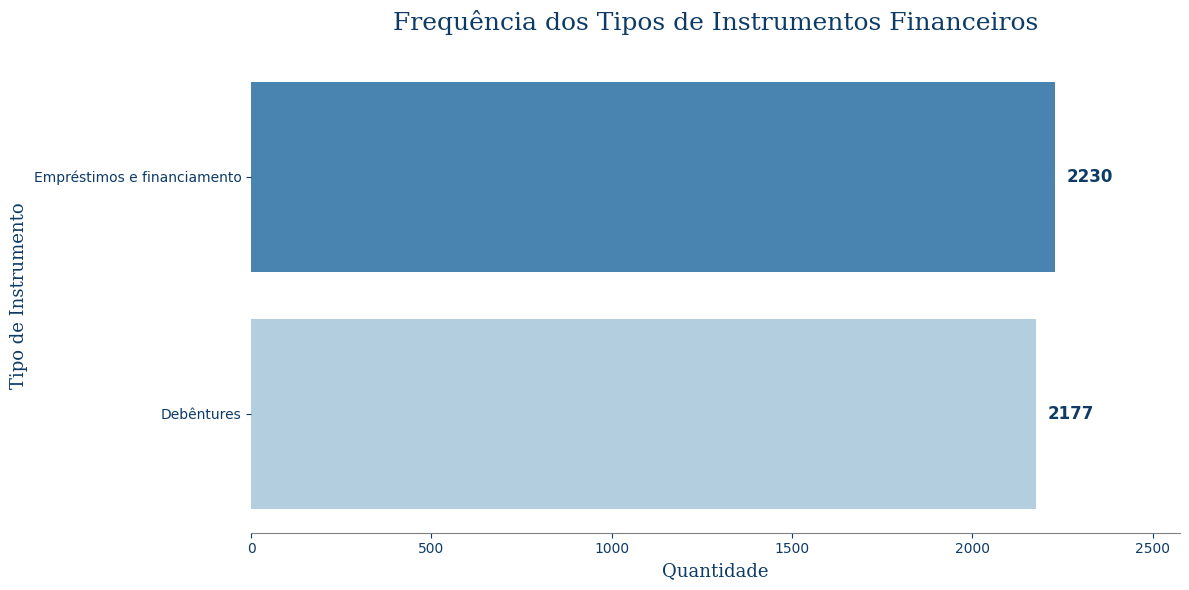

In [117]:
plt.figure(figsize=(12, 6))

ax = sns.countplot(
    data=df_filtrado.dropna(subset=["Debenture ou Empréstimos e financiamento"]),
    y="Debenture ou Empréstimos e financiamento",
    order=df_filtrado["Debenture ou Empréstimos e financiamento"].value_counts().index,
    palette=sns.color_palette("Blues_r", n_colors=df_filtrado["Debenture ou Empréstimos e financiamento"].nunique())
)

for p in ax.patches:
    width = p.get_width() 
    if width > 0:
      ax.annotate(
          f'{int(width)}',
          xy=(width, p.get_y() + p.get_height() / 2), # Posição (x,y) do texto
          xytext=(8, 0), # Deslocamento de 8 pontos para a direita
          textcoords='offset points',
          ha='left', # Alinhamento horizontal
          va='center', # Alinhamento vertical
          fontsize=12,
          color=azul_escuro,
          weight='bold'
          )

# Aumenta o limite do eixo X para dar espaço aos rótulos
plt.xlim(0, ax.get_xlim()[1] * 1.1)

plt.title("Frequência dos Tipos de Instrumentos Financeiros", fontdict=font_titulo, pad=20)
plt.xlabel("Quantidade", fontdict=font_eixos)
plt.ylabel("Tipo de Instrumento", fontdict=font_eixos)

sns.despine(left=True, bottom=False)

plt.tight_layout()
plt.show()

#### 4. Frequência de Cláusulas com Limites Definidos

C:\Users\Maria Eduarda\AppData\Local\Temp\ipykernel_12212\1915347706.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


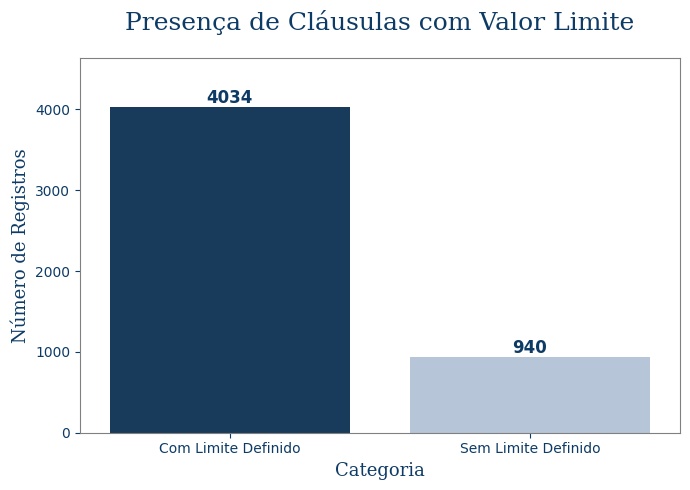

In [118]:
df_filtrado['tem_limite'] = df_filtrado['valor_limite'].notna().map({True: 'Com Limite Definido', False: 'Sem Limite Definido'})
contagem_limites = df_filtrado['tem_limite'].value_counts()

plt.figure(figsize=(7, 5))
ax = sns.barplot(
    x=contagem_limites.index,
    y=contagem_limites.values,
    palette=[azul_escuro, "#b0c4de"]
)
plt.title("Presença de Cláusulas com Valor Limite", fontdict=font_titulo, pad=20)
plt.xlabel("Categoria", fontdict=font_eixos)
plt.ylabel("Número de Registros", fontdict=font_eixos)

# Adiciona os rótulos de dados
for i, v in enumerate(contagem_limites.values):
    ax.text(i, v, str(v), ha='center', va='bottom', color=azul_escuro, fontweight='bold', size=12)

plt.ylim(0, max(contagem_limites.values) * 1.15)
plt.tight_layout()
# plt.savefig("frequencia_clausulas_limite.png")
plt.show()

##### 5. Evolução da Proporção de Covenants ao Longo do Tempo

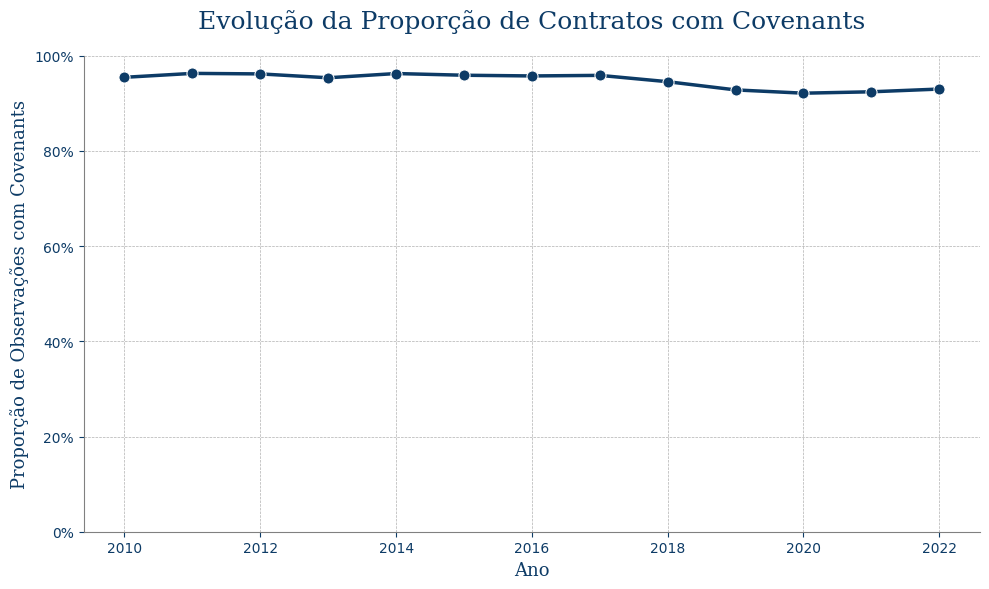

In [119]:
# Calcula a proporção de 'SIM' e 'NÃO' para cada ano
proporcao_ano = df_possui_covenant.groupby('ANO')['POSSUI COVENANT'].value_counts(normalize=True).unstack()

# Plotagem
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=proporcao_ano['SIM'], # Plota apenas a linha para 'SIM'
    marker='o',
    markersize=8,
    linewidth=2.5,
    color=azul_escuro
)

# Formata o eixo Y como porcentagem
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.title('Evolução da Proporção de Contratos com Covenants', fontdict=font_titulo, pad=20)
plt.xlabel('Ano', fontdict=font_eixos)
plt.ylabel('Proporção de Observações com Covenants', fontdict=font_eixos)
plt.ylim(0, 1) # Define o eixo Y de 0% a 100%
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine()
plt.tight_layout()
plt.show()

In [120]:
df_possui_covenant.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5274 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Empresa_Setor                             5274 non-null   object 
 1   Setor                                     5274 non-null   object 
 2   ANO                                       5274 non-null   int64  
 3   POSSUI COVENANT                           5267 non-null   object 
 4   DIVULGOU                                  5053 non-null   object 
 5   Debenture ou Empréstimos e financiamento  4411 non-null   object 
 6   Índice Utilizado                          4374 non-null   object 
 7   operador_limite                           4038 non-null   object 
 8   valor_limite                              4038 non-null   float64
 9   Violou?                                   3817 non-null   object 
 10  Limite                                   

## 🏗️ 2. **Análise dos tipos de índices utilizados**

**Objetivo**: entender os indicadores financeiros mais usados como base para os covenants.

Analise:

* Frequência de cada valor em `"Índice Utilizado"` (ex: dívida/EBITDA, cobertura de juros, etc).
* Agrupamento por tipo de índice (liquidez, rentabilidade, endividamento, etc).
* Como esses índices variam por setor.

📌 *Gráficos*: gráfico de barras horizontais com os índices mais comuns.

# `Preciso tratar os índices primeiro`

In [140]:
# Este comando substitui um ou mais caracteres de espaço ('\s+') por nada ('')
# df_filtrado['Índice Utilizado'] = df_filtrado['Índice Utilizado'].str.lower()
# df_filtrado['Índice Utilizado'] = df_filtrado['Índice Utilizado'].str.replace(r'\s+', '', regex=True)
df_filtrado['Índice Utilizado'].nunique()

242

In [144]:
# --- PIPELINE DE LIMPEZA E PADRONIZAÇÃO - VERSÃO FINAL ---

# Camada 1: Limpeza base (sem alterações, continua robusta)
def limpeza_base(texto):
    if not isinstance(texto, str):
        return 'nao informado'
    texto = str(texto).lower()
    texto = texto.replace('\n', ' ')
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

# Camada 2: Padronização de COMPONENTES (com adições)
def padronizar_componentes_v2(texto):
    mapa = {
        'endividamento financeiro liquido': 'divida liquida', 'divida financeira liquida': 'divida liquida',
        'dividas financeiras liquidas': 'divida liquida', 'ndividamento bancario liquido': 'divida liquida',
        'divida bancaria liquida': 'divida liquida', 'dívida líquida': 'divida liquida',
        'divida de curto prazo': 'divida cp', 'divida circulante': 'divida cp',
        'divida financeira total': 'divida bruta', 'divida total': 'divida bruta',
        'endividamento total': 'divida bruta', 'divida consolidada': 'divida bruta', # <-- NOVO
        'dividas': 'divida', 'ebitida': 'ebitda', 'ebit': 'ebit',
        'despesas financeiras': 'despesa financeira', 'desp. financ liquida': 'despesa financeira',
        'resultado finaneiro': 'resultado financeiro', 'encargos dividas': 'despesa financeira',
        'juros': 'despesa financeira', 'patrimonio liquido': 'pl', 'patrimônio líquido': 'pl',
        'capital proprio': 'pl', # <-- NOVO
        'ativo total': 'at', 'ativos': 'at',
        'passivo exigivel': 'passivo total', 'exigivel total': 'passivo total',
        'capital de terceiros': 'passivo total', # <-- NOVO
        'ativo circulante': 'ac', 'passivo circulante': 'pc',
        'receita operacional liquida': 'receita liquida', 'receita operacional': 'receita liquida',
        'icsd': 'icds', 'iscd': 'icds', 'icd': 'icds', 'serviço da divida': 'icds',
        'grau de endividamento': 'endividamento geral', # <-- NOVO
        'icp - indice de capitalizacao propria': 'icp', # <-- NOVO
        'índice de capitalização própria': 'icp' # <-- NOVO
    }
    for k, v in mapa.items():
        texto = texto.replace(k, v)
    return texto

# Camada 3: Reconstrução dos índices (com muitas novas regras)
def reconstruir_indice_padronizado_v2(texto):
    # --- Índices Nomeados Específicos ---
    if 'icp' in texto or ('pl' in texto and 'at' in texto): return 'ICP (PL / Ativo Total)' # <-- REGRA MELHORADA E PRIORIZADA
    if 'endividamento geral' in texto or ('passivo total' in texto and 'at' in texto): return 'Endividamento Geral (Passivo/Ativo)' # <-- REGRA MELHORADA E PRIORIZADA

    # --- Índices de Cobertura ---
    if 'ebitda' in texto and 'despesa financeira' in texto: return 'EBITDA / Despesa Financeira'
    if 'ebitda' in texto and 'resultado financeiro' in texto: return 'EBITDA / Resultado Financeiro'
    if 'ebit' in texto and 'despesa financeira' in texto: return 'EBIT / Despesa Financeira'
    if 'icds' in texto: return 'ICDS (Cobertura do Serviço da Dívida)'

    # --- Índices de Alavancagem (Endividamento) ---
    if 'divida liquida' in texto and 'ebitda' in texto:
        if 'ajustado' in texto: return 'Dívida Líquida / EBITDA Ajustado'
        return 'Dívida Líquida / EBITDA'
    if 'divida bruta' in texto and 'ebitda' in texto: return 'Dívida Bruta / EBITDA'
    if 'divida cp' in texto and 'ebitda' in texto: return 'Dívida CP / EBITDA'
    if 'divida liquida' in texto and 'pl' in texto: return 'Dívida Líquida / PL'
    if 'divida bruta' in texto and 'pl' in texto: return 'Dívida Bruta / PL'
    if 'divida liquida' in texto and 'divida liquida + pl' in texto: return 'Dívida Líquida / (Dívida Líquida + PL)'
    if 'divida liquida' in texto and 'at' in texto: return 'Dívida Líquida / Ativo Total' # <-- NOVA REGRA
    if 'passivo total' in texto and 'pl' in texto: return 'Passivo Total / PL' # <-- NOVA REGRA (Exigível/PL)
    if 'alavancagem' in texto: return 'Alavancagem Financeira (Genérico)' # <-- NOVA REGRA
    if 'divida' in texto and 'ebitda' in texto: return 'Dívida (Genérica) / EBITDA' # <-- NOVA REGRA (Pega-tudo para Dívida/EBITDA)

    # --- Índices de Liquidez ---
    if 'ac' in texto and 'pc' in texto or 'liquidez corrente' in texto: return 'Liquidez Corrente (AC/PC)'
    if 'recebiveis' in texto and 'divida liquida' in texto: return 'Recebíveis / Dívida Líquida' # <-- NOVA REGRA
    
    # --- Índices de Rentabilidade ---
    if 'margem ebitda' in texto or ('ebitda' in texto and 'receita' in texto): return 'Margem EBITDA' # <-- REGRA MELHORADA
    
    # --- Cláusulas de Valor Absoluto / Não-Financeiras ---
    if 'caixa minimo' in texto: return 'Cláusula: Caixa Mínimo'
    if 'pl minimo' in texto or 'patrimonio liquido minimo' in texto: return 'Cláusula: PL Mínimo'
    if 'restricao de investimento' in texto or 'capex' in texto: return 'Cláusula: Restrição de CAPEX'
    if 'distribuicao de lucros' in texto or 'distribuicao de resultados' in texto: return 'Cláusula: Restrição de Dividendos'
    if 'restricao de atos' in texto: return 'Cláusula: Restrição de Atos'
    if texto in ['ebitda', 'ebitda ajustado', 'divida liquida']: return f'Cláusula: Valor de {texto.upper()}' # <-- NOVA REGRA

    # --- Catch-all para o que não foi pego ---
    if len(texto) > 60 or ';' in texto or '+' in texto or ')' in texto:
        return 'Índice Específico / Contratual'
    
    return 'Índice Não Padronizado'


# --- APLICAÇÃO DO NOVO PIPELINE ---
df_filtrado['Indice_Padronizado'] = (df_filtrado['Índice Utilizado']
                                     .apply(limpeza_base)
                                     .apply(padronizar_componentes_v2)
                                     .apply(reconstruir_indice_padronizado_v2))

# --- VERIFICAÇÃO FINAL ---
print("--- Contagem Final dos Índices Padronizados ---")
contagem_final = df_filtrado['Indice_Padronizado'].value_counts()

# Configura o pandas para mostrar todas as linhas da contagem
pd.set_option('display.max_rows', None)
print(contagem_final)
pd.reset_option('display.max_rows') # Volta ao padrão

# Verifica o que SOBROU em 'Não Padronizado'
df_nao_padronizado_final = df_filtrado[df_filtrado['Indice_Padronizado'] == 'Índice Não Padronizado']
print(f"\n--- Número de índices que AINDA não foram padronizados: {len(df_nao_padronizado_final)} ---")
if not df_nao_padronizado_final.empty:
    print("Amostra do que sobrou:")
    print(df_nao_padronizado_final['Índice Utilizado'].value_counts().head(10))

--- Contagem Final dos Índices Padronizados ---
Indice_Padronizado
Dívida Líquida / EBITDA                  1805
Índice Não Padronizado                    926
EBITDA / Despesa Financeira               547
ICDS (Cobertura do Serviço da Dívida)     406
Dívida Líquida / PL                       321
EBITDA / Resultado Financeiro             302
Liquidez Corrente (AC/PC)                 162
ICP (PL / Ativo Total)                    111
Índice Específico / Contratual            104
Margem EBITDA                              80
Dívida Líquida / EBITDA Ajustado           71
Passivo Total / PL                         40
Endividamento Geral (Passivo/Ativo)        32
EBIT / Despesa Financeira                  24
Dívida (Genérica) / EBITDA                 15
Dívida Líquida / Ativo Total               13
Alavancagem Financeira (Genérico)           8
Cláusula: Valor de EBITDA AJUSTADO          2
Cláusula: Valor de DIVIDA LIQUIDA           2
Cláusula: Restrição de CAPEX                2
Cláusula: Val

In [145]:
# Filtra o DataFrame para pegar apenas as linhas que nossa função não conseguiu classificar
df_para_corrigir = df_filtrado[df_filtrado['Indice_Padronizado'] == 'Índice Não Padronizado']
print(f"Número de índices a serem reclassificados: {len(df_para_corrigir)}")
# Faz uma contagem de frequência dos textos ORIGINAIS que não foram padronizados
contagem_erros = df_para_corrigir['Índice Utilizado'].value_counts()
contagem_erros.head(100)

Número de índices a serem reclassificados: 926


Índice Utilizado
Exigível total/patrimônio líquido                     29
Dívida Bruta/EBITDA                                   28
Recebíveis / Dívida Líquida                           22
Dívida Total/EBITDA                                   20
endividamento de curto prazo / endividamento total    17
                                                      ..
Capital Social / ativo imobilizado                     1
Geração de caixa/ serviço da dívida                    1
Dívida Total de Curto Prazo/EBITDA                     1
Dívida de Curto Prazo/EBITDA                           1
EBITDA/  dívida de curto prazo                         1
Name: count, Length: 70, dtype: int64

In [146]:
nome_do_arquivo = 'indices_nao_padronizados.txt'

# 3. Salvar a série 'contagem_erros' no arquivo de texto
contagem_erros.to_csv(
    nome_do_arquivo, 
    sep='\t',            # Separador: usa uma tabulação (TAB) para alinhar bem o texto e a contagem
    header=False,        # Não adiciona uma linha de cabeçalho
    encoding='utf-8'     # Garante que acentos e caracteres especiais sejam salvos corretamente
)

print(f"Arquivo '{nome_do_arquivo}' foi criado com sucesso!")
print("Ele contém a lista de índices não padronizados e suas respectivas frequências.")


Arquivo 'indices_nao_padronizados.txt' foi criado com sucesso!
Ele contém a lista de índices não padronizados e suas respectivas frequências.


In [ ]:
tabela_frequencia = pd.crosstab(
    df_filtrado['Indice_Padronizado'],
    df_filtrado['ANO']
)

# Garante que todos os anos no intervalo de seus dados apareçam, preenchendo com 0 se não houver dados
if not tabela_frequencia.empty:
    todos_os_anos = range(tabela_frequencia.columns.min(), tabela_frequencia.columns.max() + 1)
    tabela_frequencia = tabela_frequencia.reindex(columns=todos_os_anos, fill_value=0)

# Passo 2: Adicionar a coluna 'Total'
tabela_frequencia['Total'] = tabela_frequencia.sum(axis=1)

# Passo 3: Ordenar a tabela pela coluna 'Total' em ordem decrescente
tabela_frequencia = tabela_frequencia.sort_values(by='Total', ascending=False)

# Passo 4: Calcular e adicionar a coluna 'Freq. (%)'
total_geral_covenants = tabela_frequencia['Total'].sum()
if total_geral_covenants > 0:
    tabela_frequencia['Freq. (%)'] = (tabela_frequencia['Total'] / total_geral_covenants) * 100
else:
    tabela_frequencia['Freq. (%)'] = 0

# Passo 5: Adicionar a linha de 'Total' ao final
soma_colunas = tabela_frequencia.sum()
soma_colunas.name = 'Total Geral'
tabela_frequencia = pd.concat([tabela_frequencia, soma_colunas.to_frame().T])


# Passo 6: Formatação final para apresentação (ótimo para notebooks)
# Isso cria uma visualização estilizada da tabela
tabela_final_formatada = tabela_frequencia.style.format({
    **{ano: '{:.0f}' for ano in todos_os_anos}, # Anos como números inteiros
    'Total': '{:.0f}',                          # Total como número inteiro
    'Freq. (%)': '{:.1f}%'                      # Frequência com 1 casa decimal e '%'
}).bar(subset=['Freq. (%)'], color='#cce5ff', vmin=0)


# Exibe a tabela final formatada
tabela_final_formatada

ANO,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,Total,Freq. (%)
Dívida Líquida / EBITDA,51,86,90,93,116,129,137,144,144,166,197,215,237,1805,36.3%
Índice Não Padronizado,83,93,91,80,83,83,87,103,95,94,92,84,83,1151,23.1%
EBITDA / Despesa Financeira,28,31,38,39,44,51,48,50,51,44,43,40,40,547,11.0%
ICDS (Cobertura do Serviço da Dívida),21,26,30,32,32,29,33,37,32,31,32,33,38,406,8.2%
Dívida Líquida / PL,12,20,22,27,30,28,22,20,21,24,34,32,29,321,6.5%
EBITDA / Resultado Financeiro,14,20,19,22,21,21,23,27,25,27,27,28,28,302,6.1%
Liquidez Corrente (AC/PC),12,16,17,15,14,13,14,14,12,9,8,10,8,162,3.3%
Índice Específico / Contratual,5,9,7,10,9,9,6,9,3,7,6,6,7,93,1.9%
Dívida Líquida / EBITDA Ajustado,0,0,2,2,2,2,2,4,6,17,10,9,15,71,1.4%
PL / Ativo Total,1,3,3,4,4,4,6,6,6,5,5,5,2,54,1.1%



## 🏢 5. **Setores mais expostos a covenants**

**Com a variável `Setor` adicionada**, você pode:

* Ver a proporção de empresas por setor que têm cláusulas de covenant.
* Quais setores mais divulgam os termos?
* Quais setores têm limites mais rígidos?
* Quais setores mais violam cláusulas?

📌 *Gráficos*: barras, heatmaps, scatterplots de valor do limite × setor.

C:\Users\Maria Eduarda\AppData\Local\Temp\ipykernel_12212\1446711462.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


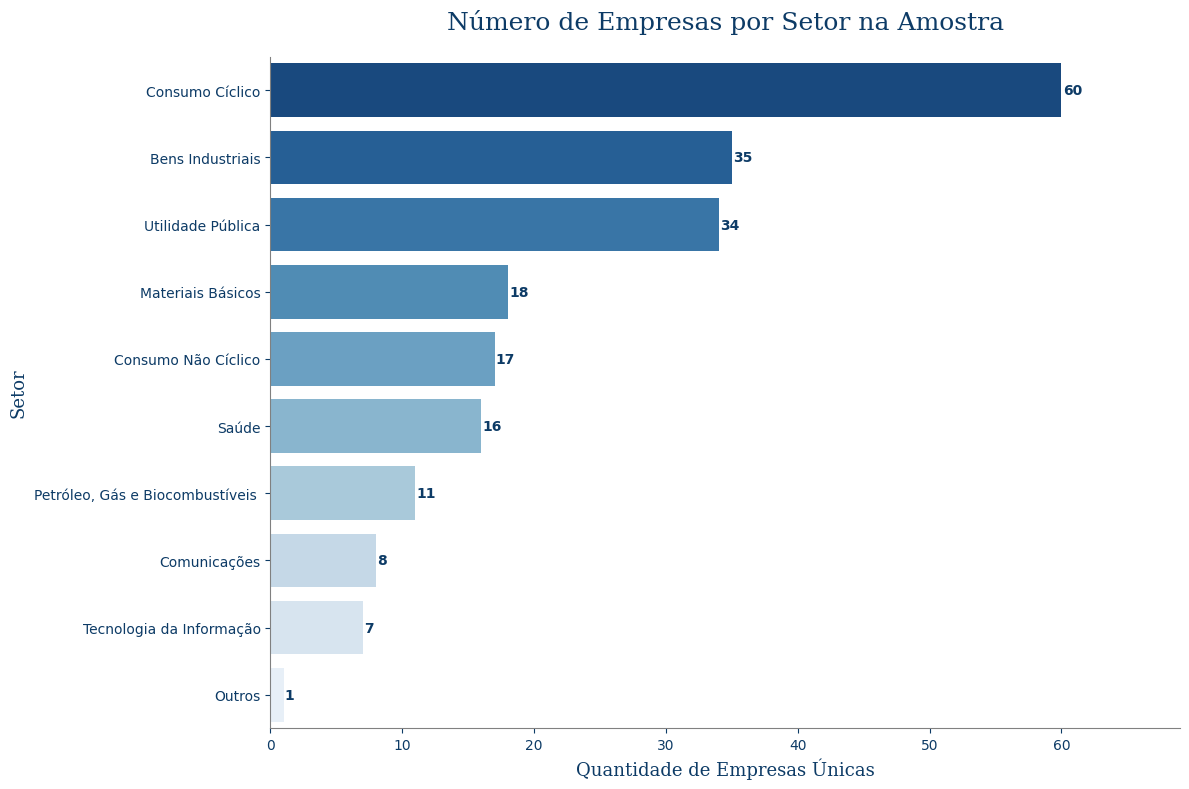

In [ ]:
empresas_por_setor = df_filtrado.groupby('Setor')['EMPRESA'].nunique().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x=empresas_por_setor.values,
    y=empresas_por_setor.index,
    palette="Blues_r"
)

# Adiciona os rótulos de dados
for i, v in enumerate(empresas_por_setor.values):
    ax.text(v + 0.1, i, str(v), color=azul_escuro, va='center', fontweight='bold')

plt.title('Número de Empresas por Setor na Amostra', fontdict=font_titulo, pad=20)
plt.xlabel('Quantidade de Empresas Únicas', fontdict=font_eixos)
plt.ylabel('Setor', fontdict=font_eixos)
plt.xlim(0, empresas_por_setor.max() * 1.15) # Espaço extra para os rótulos
sns.despine()
plt.tight_layout()
plt.show()

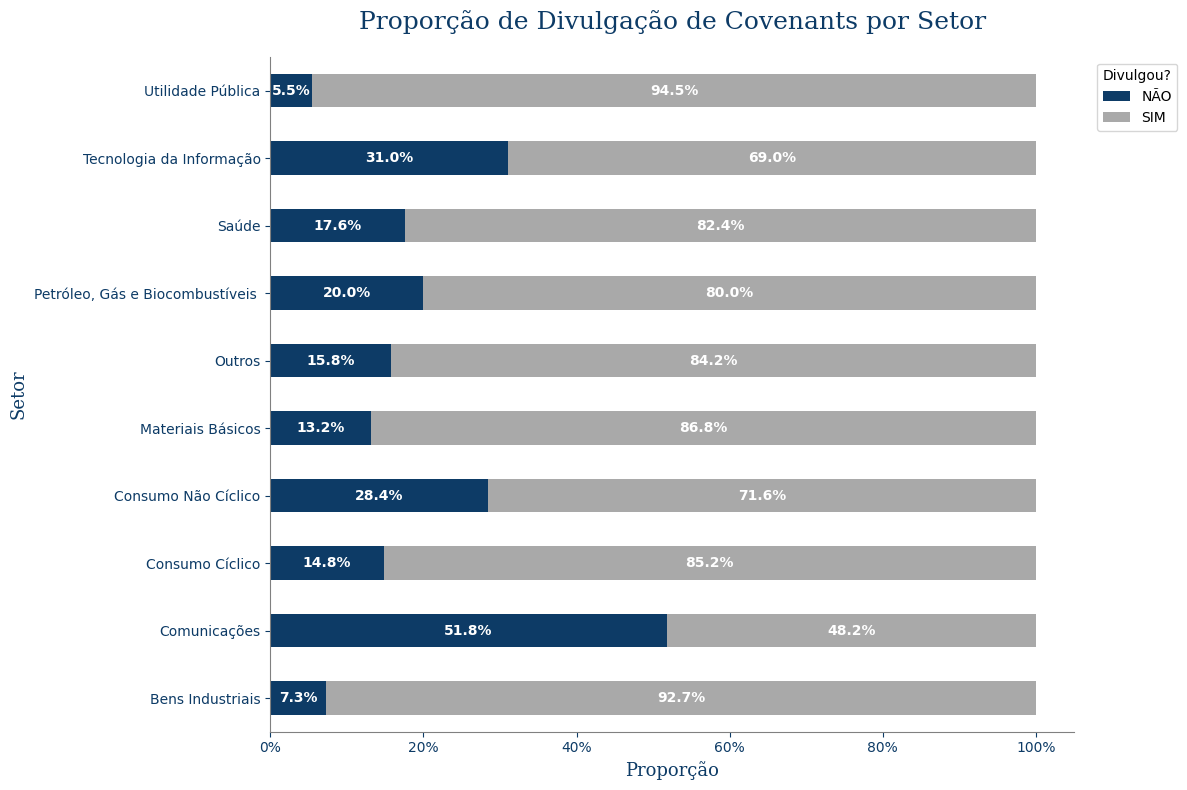

In [ ]:
# Cria uma tabela de contingência
tabela_divulgacao = pd.crosstab(df_filtrado['Setor'], df_filtrado['DIVULGOU'])

# Normaliza a tabela para que a soma de cada linha seja 1 (100%)
tabela_norm = tabela_divulgacao.div(tabela_divulgacao.sum(axis=1), axis=0)

# Plotagem
ax = tabela_norm.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 8),
    color=[azul_escuro, '#a9a9a9'] # 'SIM' em azul, 'NÃO' em cinza
)

# Adiciona os rótulos de porcentagem
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if width > 0:
        ax.text(x + width/2,
                y + height/2,
                f'{width:.1%}', # Formata como porcentagem
                ha='center',
                va='center',
                color='white',
                fontweight='bold')

plt.title('Proporção de Divulgação de Covenants por Setor', fontdict=font_titulo, pad=20)
plt.xlabel('Proporção', fontdict=font_eixos)
plt.ylabel('Setor', fontdict=font_eixos)
plt.legend(title='Divulgou?', bbox_to_anchor=(1.02, 1), loc='upper left') # Legenda fora do gráfico
ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format)) # Formata o eixo X como %
sns.despine()
plt.tight_layout()
plt.show()



---



---

## 📊 3. **Distribuição dos limites numéricos**

**Objetivo**: avaliar os **valores definidos nos contratos** como critérios para quebra de covenant.

* Distribuição dos valores numéricos extraídos (`valor_limite`) por índice.
* Diferença nos limites definidos por setor.
* Comparar limites para empresas que **violaram** e **não violaram**.

📌 *Gráficos*: boxplots por índice, por setor, por status de violação.

---

## 🚨 4. **Análise de violação**

**Objetivo**: identificar padrão de violação contratual.

* Percentual de empresas que violaram covenants (`"Violou?" == 'sim'`).
* Comparar com a média do índice (se tiver os valores reais dos indicadores).
* Quais índices têm maior taxa de violação?
* Existe associação entre tipo de índice e violação?

📌 *Gráficos*: barras empilhadas, heatmaps.

---


---

## 📅 6. **Evolução temporal**

**Se tiver a variável `ANO` bem preenchida**:

* Evolução do uso de covenants ao longo do tempo.
* Mudança nos limites definidos ano a ano.
* Tendência de divulgação e violação.

📌 *Gráficos*: linhas por ano, área acumulada, barras temporais.

---

## 🔍 7. **Casos qualitativos especiais**

Você pode mencionar ou classificar manualmente:

* Limites com condições não numéricas (ex: `"menor ou igual a 75% da depreciação"`).
* Cláusulas que envolvem múltiplos critérios (`"maior ou igual a 1,5 ou menor que 0"`).
* Casos com valor em R\$, milhões, ou pagamentos parcelados.

📌 *Sugestão*: construir uma tabela de exemplos e agrupar por "não padronizável", "qualitativo", "financeiro monetário", etc.

---

## 📚 8. **Discussão econométrica (opcional)**

Se tiver tempo e dados complementares:

* Você pode rodar uma regressão para **estimar a probabilidade de violação**, com variáveis como:

  * tipo de índice
  * setor
  * ano
  * valor do limite
  * tipo de instrumento (debênture vs empréstimo)

📌 *Modelo sugerido*: regressão logística.

---

## ✨ Exemplos de perguntas para seu artigo

* "Quais índices são mais usados como covenants nas empresas listadas da B3?"
* "Há setores que enfrentam cláusulas mais restritivas?"
* "Os limites definidos nos contratos mudaram com o tempo?"
* "As cláusulas são efetivas? Há alto índice de violação?"
* "Existe alguma evidência de que empresas com covenants apresentam melhor governança?
